In [141]:
import numpy as np 
import pandas as pd 
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

%matplotlib inline

In [2]:
!pip install xgboost

     |████████████████████████████████| 2.2 MB 3.4 MB/s eta 0:00:01
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [50]:
import xgboost as xgb

## Data preparation & Cleaning

#### Read data with pandas

In [51]:
# Read CSVs into dataframes
players_df = pd.read_csv("./data-raw/players.csv")
games_df = pd.read_csv("./data-raw/games.csv")
appearances_df = pd.read_csv("./data-raw/appearances.csv")

In [52]:
len(players_df), len(games_df), len(appearances_df)

(30302, 64434, 1489578)

In [53]:
players_df.dtypes

player_id                                 int64
first_name                               object
last_name                                object
name                                     object
last_season                               int64
current_club_id                           int64
player_code                              object
country_of_birth                         object
city_of_birth                            object
country_of_citizenship                   object
date_of_birth                            object
sub_position                             object
position                                 object
foot                                     object
height_in_cm                            float64
market_value_in_eur                     float64
highest_market_value_in_eur             float64
contract_expiration_date                 object
agent_name                               object
image_url                                object
url                                     

In [54]:
games_df.dtypes

game_id                     int64
competition_id             object
season                      int64
round                      object
date                       object
home_club_id                int64
away_club_id                int64
home_club_goals             int64
away_club_goals             int64
home_club_position        float64
away_club_position        float64
home_club_manager_name     object
away_club_manager_name     object
stadium                    object
attendance                float64
referee                    object
url                        object
home_club_formation        object
away_club_formation        object
home_club_name             object
away_club_name             object
aggregate                  object
competition_type           object
dtype: object

In [55]:
appearances_df.dtypes

appearance_id             object
game_id                    int64
player_id                  int64
player_club_id             int64
player_current_club_id     int64
date                      object
player_name               object
competition_id            object
yellow_cards               int64
red_cards                  int64
goals                      int64
assists                    int64
minutes_played             int64
dtype: object

#### Take most updated playes data only 

In [56]:
# check most update players's last season 
players_df['last_season'].unique()

array([2014, 2012, 2013, 2015, 2017, 2020, 2018, 2019, 2016, 2021, 2022,
       2023])

In [57]:
players_df = players_df[players_df["last_season"] == 2023]
len(players_df)

6539

#### Merge all data player to get final dataset

In [58]:
games_and_apps_df = appearances_df.merge(games_df, on=['game_id'], how='left')

def get_player_stats(player_id, season, df):
    
    df = df[df['player_id'] == player_id]
    df = df[df['season'] == season]
    
    if (df.shape[0] == 0):
        Out = [(np.nan, season,0,0,0,0,0,0,0)]
        out_df = pd.DataFrame(data = Out, columns = ['player_id','season','goals','games',
                                                     'assists','minutes_played','goals_for','goals_against','clean_sheet'])
        return out_df
    
    else:
        
        df["goals_for"] = df.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
                      else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
                      else np.nan, axis=1)
        df["goals_against"] = df.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
                      else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
                      else np.nan, axis=1)
        df['clean_sheet'] = df.apply(lambda row: 1 if row['goals_against'] == 0
                      else 0 if row['goals_against'] > 0
                      else np.nan, axis=1)
        
        df = df.groupby(['player_id',"season"],as_index=False).agg({'goals': 'sum', 'game_id': 'nunique', 
                                                                      'assists': 'sum', 'minutes_played' : 'sum', 'goals_for' : 'sum',
                                                                      'goals_against' : 'sum', 'clean_sheet' : 'sum'})
        out_df = df.rename(columns={'game_id': 'games'})

        return out_df
    
    
stat_season = 2022
for index in players_df.index:
    id = players_df.loc[index][0]
    name = players_df.loc[index][1]
    stats = get_player_stats(id, stat_season, games_and_apps_df)
    players_df.at[index,'goals_{}'.format(stat_season)]= stats['goals'][0]
    players_df.at[index,'games_{}'.format(stat_season)]= stats['games'][0]
    players_df.at[index,'assists_{}'.format(stat_season)]= stats['assists'][0]
    players_df.at[index,'minutes_played_{}'.format(stat_season)]= stats['minutes_played'][0]
    players_df.at[index,'goals_for_{}'.format(stat_season)]= stats['goals_for'][0]
    players_df.at[index,'goals_against_{}'.format(stat_season)]= stats['goals_against'][0]
    players_df.at[index,'clean_sheet_{}'.format(stat_season)]= stats['clean_sheet'][0]

In [59]:
players_df.columns

Index(['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth',
       'country_of_citizenship', 'date_of_birth', 'sub_position', 'position',
       'foot', 'height_in_cm', 'market_value_in_eur',
       'highest_market_value_in_eur', 'contract_expiration_date', 'agent_name',
       'image_url', 'url', 'current_club_domestic_competition_id',
       'current_club_name', 'goals_2022', 'games_2022', 'assists_2022',
       'minutes_played_2022', 'goals_for_2022', 'goals_against_2022',
       'clean_sheet_2022'],
      dtype='object')

In [60]:
# we dont have age column, but can construct it from date of birth
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])


players_df = players_df[players_df['date_of_birth'].isnull() == False]
now = datetime.now()

players_df['age'] = (now - players_df['date_of_birth']).apply(lambda x: x.days) / 365.25
players_df['age'] = players_df['age'].round().astype(int)

#### Handling missing value with drop 

In [61]:
players_df.isnull().sum()

player_id                                  0
first_name                               384
last_name                                  0
name                                       0
last_season                                0
current_club_id                            0
player_code                                0
country_of_birth                         362
city_of_birth                            360
country_of_citizenship                     0
date_of_birth                              0
sub_position                               2
position                                   0
foot                                     222
height_in_cm                             225
market_value_in_eur                       46
highest_market_value_in_eur               45
contract_expiration_date                 226
agent_name                              2000
image_url                                  0
url                                        0
current_club_domestic_competition_id       0
current_cl

In [62]:
# we only care missing value in importants columns
players_df = players_df.dropna(subset = ['foot','height_in_cm','market_value_in_eur','highest_market_value_in_eur'])
players_df.isnull().sum()

player_id                                  0
first_name                               378
last_name                                  0
name                                       0
last_season                                0
current_club_id                            0
player_code                                0
country_of_birth                         225
city_of_birth                            225
country_of_citizenship                     0
date_of_birth                              0
sub_position                               0
position                                   0
foot                                       0
height_in_cm                               0
market_value_in_eur                        0
highest_market_value_in_eur                0
contract_expiration_date                 179
agent_name                              1839
image_url                                  0
url                                        0
current_club_domestic_competition_id       0
current_cl

In [63]:
len(players_df)

6170

In [64]:
#reset index of dataset
players_df = players_df.reset_index(drop=True)
players_df

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,current_club_domestic_competition_id,current_club_name,goals_2022,games_2022,assists_2022,minutes_played_2022,goals_for_2022,goals_against_2022,clean_sheet_2022,age
0,22860,Jesper,Hansen,Jesper Hansen,2023,678,jesper-hansen,Denmark,Slangerup,Denmark,...,DK1,Aarhus GF,0.0,25.0,0.0,2250.0,37.0,22.0,9.0,39
1,30321,Óscar,Trejo,Óscar Trejo,2023,367,oscar-trejo,Argentina,Santiago del Estero,Argentina,...,ES1,Rayo Vallecano,3.0,37.0,5.0,2306.0,47.0,52.0,8.0,36
2,38780,Vítor,Gomes,Vítor Gomes,2023,2425,vitor-gomes,Portugal,Vila do Conde,Portugal,...,PO1,Rio Ave FC,0.0,22.0,1.0,826.0,28.0,30.0,8.0,36
3,40204,Joe,Hart,Joe Hart,2023,371,joe-hart,England,Shrewsbury,England,...,SC1,Celtic FC,0.0,44.0,0.0,3960.0,124.0,42.0,17.0,37
4,43250,Jan,Vertonghen,Jan Vertonghen,2023,58,jan-vertonghen,Belgium,Sint-Niklaas,Belgium,...,BE1,RSC Anderlecht,1.0,25.0,0.0,2078.0,37.0,36.0,9.0,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165,1025424,Solomon,Agbalaka,Solomon Agbalaka,2023,41231,solomon-agbalaka,NaN,NaN,Nigeria,...,RU1,FC Sochi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20
6166,284732,Ramy,Bensebaini,Ramy Bensebaini,2023,16,ramy-bensebaini,Algeria,Constantine,Algeria,...,L1,Borussia Dortmund,7.0,30.0,1.0,2570.0,55.0,44.0,9.0,29
6167,371851,Jaka,Bijol,Jaka Bijol,2023,410,jaka-bijol,Slovenia,Vuzenica,Slovenia,...,IT1,Udinese Calcio,3.0,33.0,2.0,2805.0,39.0,39.0,10.0,25
6168,586756,Festy,Ebosele,Festy Ebosele,2023,410,festy-ebosele,Ireland,"Enniscorthy, Wexford",Ireland,...,IT1,Udinese Calcio,0.0,18.0,1.0,446.0,20.0,27.0,4.0,21


## EDA

### Basic Statistic

In [65]:
#see each column data statistic
for col in players_df.columns:
    print("========== {} ==========".format(col) )
    print("sample data: {} ".format(players_df[col].unique()[:5]))
    print("no. of unique value: {} ".format(players_df[col].nunique()))
    print()

========== player_id ==========
sample data: [22860 30321 38780 40204 43250] 
no. of unique value: 6170 

========== first_name ==========
sample data: ['Jesper' 'Óscar' 'Vítor' 'Joe' 'Jan'] 
no. of unique value: 2463 

========== last_name ==========
sample data: ['Hansen' 'Trejo' 'Gomes' 'Hart' 'Vertonghen'] 
no. of unique value: 5364 

========== name ==========
sample data: ['Jesper Hansen' 'Óscar Trejo' 'Vítor Gomes' 'Joe Hart' 'Jan Vertonghen'] 
no. of unique value: 6135 

========== last_season ==========
sample data: [2023] 
no. of unique value: 1 

========== current_club_id ==========
sample data: [ 678  367 2425  371   58] 
no. of unique value: 238 

========== player_code ==========
sample data: ['jesper-hansen' 'oscar-trejo' 'vitor-gomes' 'joe-hart' 'jan-vertonghen'] 
no. of unique value: 6133 

========== country_of_birth ==========
sample data: ['Denmark' 'Argentina' 'Portugal' 'England' 'Belgium'] 
no. of unique value: 141 

========== city_of_birth ==========
sample da

#### player's age distribution

<Axes: xlabel='age'>

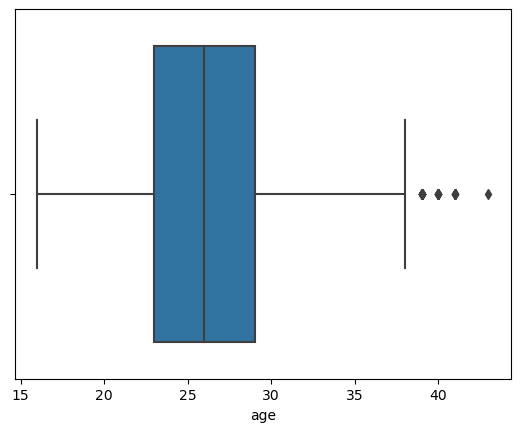

In [66]:
sns.boxplot(x=players_df["age"])

<Axes: xlabel='age', ylabel='Count'>

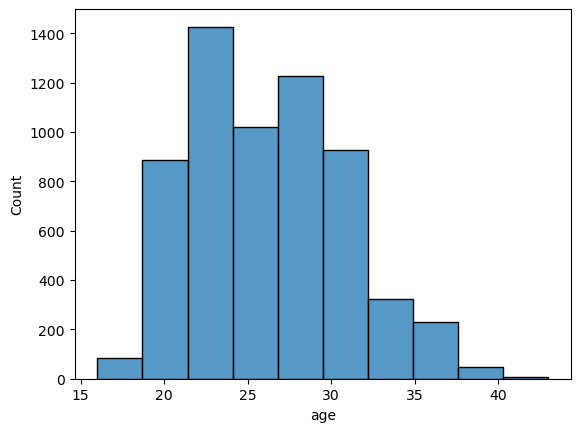

In [67]:
sns.histplot(players_df.age, bins=10)

#### The most goal player in 2022

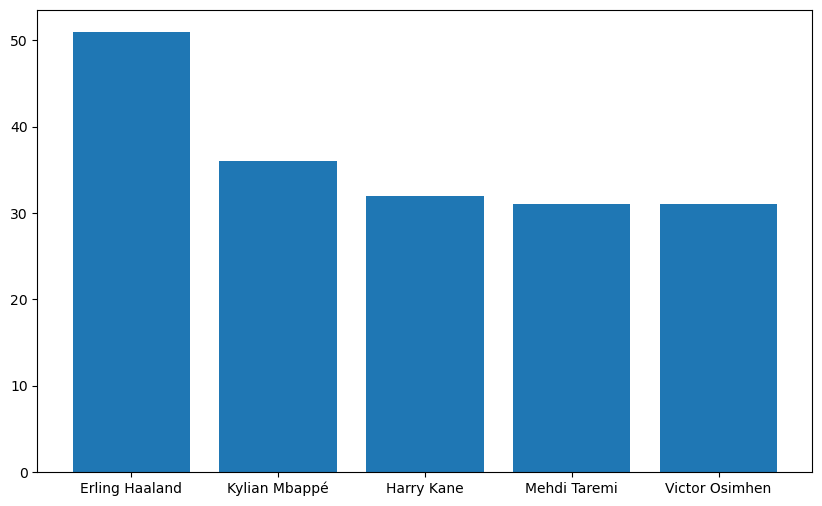

In [68]:
top5_names = players_df.sort_values(by=['goals_2022'], ascending=False).head(5)['name']
top5_goals = players_df.sort_values(by=['goals_2022'], ascending=False).head(5)['goals_2022']

fig = plt.figure(figsize =(10, 6))
 
plt.bar(top5_names, top5_goals)
 
# Show Plot
plt.show()

#### Highest market value player in 2023 (in Euro)

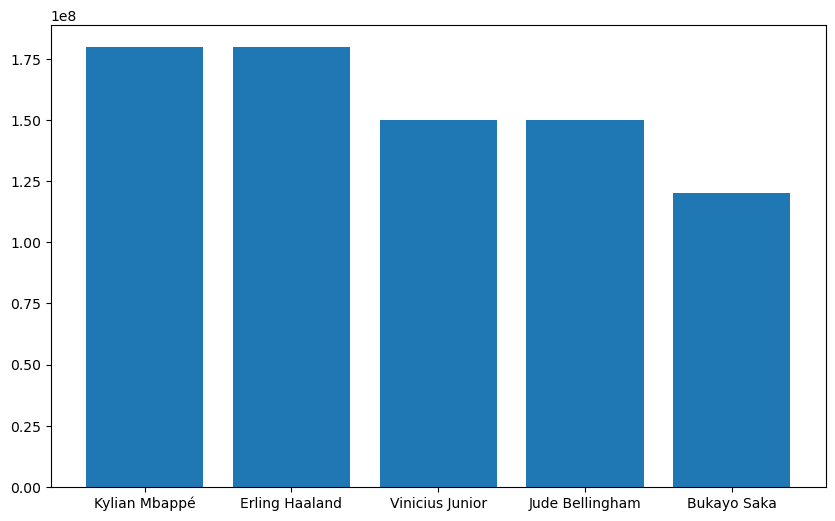

In [69]:
top5_names = players_df.sort_values(by=['market_value_in_eur'], ascending=False).head(5)['name']
top5_market_values = players_df.sort_values(by=['market_value_in_eur'], ascending=False).head(5)['market_value_in_eur']

fig = plt.figure(figsize =(10, 6))
 
plt.bar(top5_names, top5_market_values)
 
# Show Plot
plt.show()

### Target Variable Analysis

Here we use market_value_in_eur column as our target variable \
market_value_in_eur is latest value of the player in euro currency

<Axes: xlabel='market_value_in_eur', ylabel='Count'>

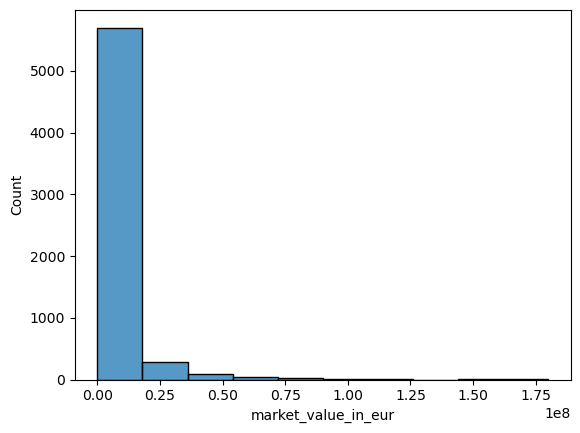

In [70]:
#show the distribution of player's market value
#looked a long tail distribution
sns.histplot(players_df['market_value_in_eur'], bins=10)

<Axes: xlabel='market_value_in_eur', ylabel='Count'>

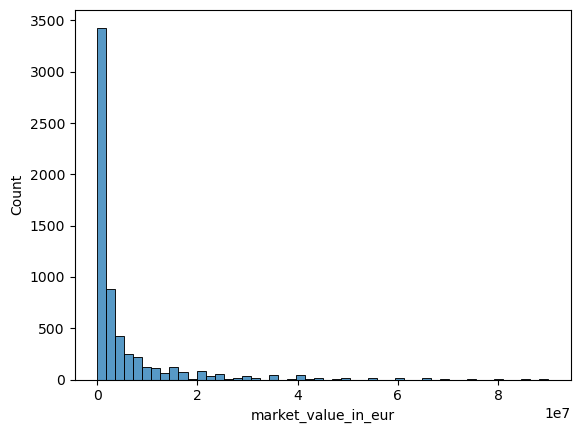

In [71]:
#zoom in to below 1000000000
sns.histplot(players_df['market_value_in_eur'][players_df['market_value_in_eur'] < 100000000], bins=50)

In [72]:
#Applies log transformation to a variable and adds one to each result for normalize the distribution
#Log transformation makes great distance of data dissemination become smaller
#here we transform the distribution to normal dist since long tail dist often confuse the ML models
market_value_logs = np.log1p(players_df['market_value_in_eur'])

<Axes: xlabel='market_value_in_eur', ylabel='Count'>

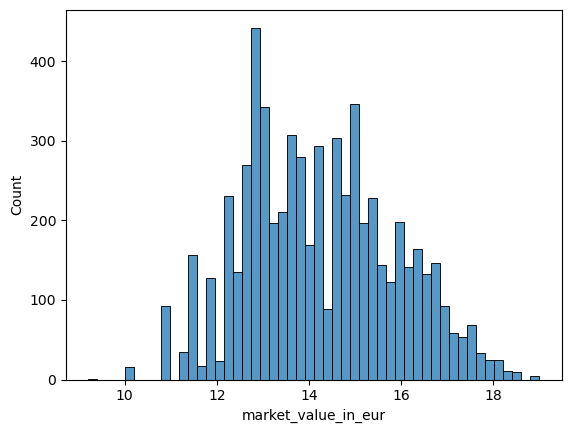

In [73]:
sns.histplot(market_value_logs, bins=50)

### Feature Importance Analysis

In [74]:
players_df.dtypes

player_id                                        int64
first_name                                      object
last_name                                       object
name                                            object
last_season                                      int64
current_club_id                                  int64
player_code                                     object
country_of_birth                                object
city_of_birth                                   object
country_of_citizenship                          object
date_of_birth                           datetime64[ns]
sub_position                                    object
position                                        object
foot                                            object
height_in_cm                                   float64
market_value_in_eur                            float64
highest_market_value_in_eur                    float64
contract_expiration_date                        object
agent_name

In [75]:
#pick relavant feature to train and divide it based the type of data
numerical_features = ['height_in_cm',
                      'goals_2022',
                      'games_2022',
                      'assists_2022',
                      'minutes_played_2022',
                      'goals_for_2022',
                      'goals_against_2022',
                      'clean_sheet_2022',
                      'age'
                     ]
categorical_features = ['position',
                        'sub_position',
                        'foot',
                        'current_club_name',
                        'current_club_domestic_competition_id'
                       ]

#### Categorical data importance analysis: mutual information

In [76]:
mutual_info_score(players_df.market_value_in_eur, players_df.position)

0.06008489366697176

In [77]:
def mutual_info_marketvalue_score(series):
    return mutual_info_score(series, players_df.market_value_in_eur)

In [78]:
mi = players_df[categorical_features].apply(mutual_info_marketvalue_score)
mi.sort_values(ascending=False)

current_club_name                       1.359951
current_club_domestic_competition_id    0.436970
sub_position                            0.134787
position                                0.060085
foot                                    0.017598
dtype: float64

#### Numerical data importance analysis: pearson correlation

In [79]:
players_df[numerical_features].corrwith(players_df.market_value_in_eur).abs()

height_in_cm           0.018153
goals_2022             0.465034
games_2022             0.444302
assists_2022           0.448892
minutes_played_2022    0.448644
goals_for_2022         0.521528
goals_against_2022     0.326417
clean_sheet_2022       0.486316
age                    0.066521
dtype: float64

## SPLIT DATASET

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
df_full_train, df_test = train_test_split(players_df, test_size=0.2, random_state=1)

In [82]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [83]:
len(df_train), len(df_val), len(df_test)

(3702, 1234, 1234)

In [84]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [85]:
#applies log transformation for each target "y" to each datasets
y_train = np.log1p(df_train.market_value_in_eur.values)
y_val = np.log1p(df_val.market_value_in_eur.values)
y_test = np.log1p(df_test.market_value_in_eur.values)

In [86]:
#remove target "y" data to make sure target not included in training process
del df_train["market_value_in_eur"]
del df_val["market_value_in_eur"]
del df_test["market_value_in_eur"]

## Metrics

In [111]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

## Train Baseline Model

Use all numerical feature (without categorical and feature selection) for baseline model \
Baseline model is use linear regression

In [88]:
def prepare_X(df):
    X = df.values
    return X

In [89]:
X_train = prepare_X(df_train[numerical_features])

reg = LinearRegression().fit(X_train, y_train)

X_val = prepare_X(df_val[numerical_features])

y_pred = reg.predict(X_val)

rmse(y_val, y_pred)

1.1880789949822215

## Train Model

### Linear Regression 

In [90]:
#Prepare data with one hot encoding
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_features + numerical_features].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [91]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_val)
rmse(y_val, y_pred)

0.8808142043423572

#### Linear Regression with Ridge Regularization

In [92]:
regRidge = Ridge(alpha=0.1)
regRidge.fit(X_train, y_train)
y_pred = regRidge.predict(X_val)
rmse(y_val, y_pred)

0.8802370798073857

#### Linear Regression with Lasso Regularization

In [93]:
regLasso = Lasso(alpha=0.1)
regLasso.fit(X_train, y_train)
y_pred = regLasso.predict(X_val)
rmse(y_val, y_pred)

1.1588153364443219

#### Tuning model

From the three linear regression model we got "linear regression with ridge" as the best. now we fine tune the alpha of the best model

In [94]:
for alpha in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:
    regRidge = Ridge(alpha=alpha)
    regRidge.fit(X_train, y_train)
    y_pred = regRidge.predict(X_val)
    print("==== RMSE ====")
    print("alpha={} : {} ".format(alpha,rmse(y_val, y_pred)))
    

==== RMSE ====
alpha=0.0 : 7.420215575191307 
==== RMSE ====
alpha=1e-05 : 0.8808106242182849 
==== RMSE ====
alpha=0.0001 : 0.8808100939304204 
==== RMSE ====
alpha=0.001 : 0.8808047924685687 
==== RMSE ====
alpha=0.1 : 0.8802370798073857 
==== RMSE ====
alpha=1 : 0.876262872732595 
==== RMSE ====
alpha=10 : 0.8745099271702509 


We got the best score of rmse (0.8745) from params: **alpha: 10** 

In [95]:
#the best model is : linear regression with ridge regularization with alpha=10
best_linear_model = Ridge(alpha=10)
best_linear_model.fit(X_train, y_train)

Ridge(alpha=10)

### Decision Tree

In [112]:
dt = DecisionTreeRegressor(max_depth=2, min_samples_leaf=50, random_state=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, min_samples_leaf=50, random_state=1)

In [113]:
y_pred = rf.predict(X_val)
y_pred

array([13.38580757, 15.05114391, 15.05114391, ..., 15.05114391,
       15.05114391, 13.38580757])

In [114]:
y_val

array([13.71015115, 14.50865824, 12.61154109, ..., 16.45456796,
       16.11809575, 10.81979828])

In [115]:
round(rmse(y_val, y_pred),3)

1.231

#### Tuning model

In [123]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict(X_val)
        rmse_score = rmse(y_val, y_pred)
        
        scores.append((depth, s, rmse_score))

In [124]:
columns = ['max_depth', 'min_samples_leaf', 'rmse_score']
df_scores = pd.DataFrame(scores, columns=columns)

In [135]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['rmse_score'])
df_scores_pivot.round(4)

rmse_score                
max_depth                 4       5       6
min_samples_leaf                           
1                    1.1165  1.0894  1.0614
5                    1.1165  1.0891  1.0610
10                   1.1159  1.0840  1.0548
15                   1.1165  1.0814  1.0542
20                   1.1175  1.0813  1.0546
100                  1.1438  1.1262  1.1100
200                  1.1921  1.1851  1.1807
500                  1.2558  1.2558  1.2558

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

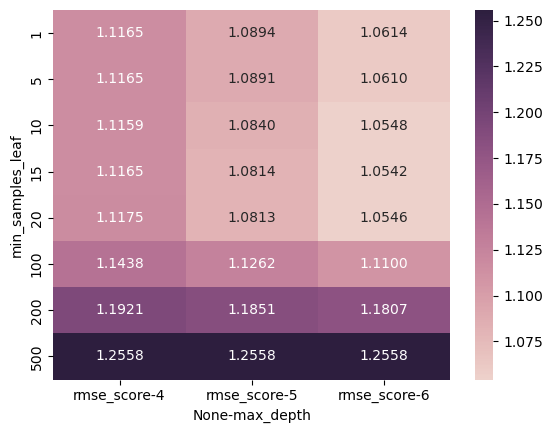

In [137]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".4f", cmap=sns.cubehelix_palette(as_cmap=True))

In [142]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- goals_for_2022 <= 31.50
|   |--- goals_for_2022 <= 14.50
|   |   |--- sub_position=Goalkeeper <= 0.50
|   |   |   |--- age <= 21.50
|   |   |   |   |--- value: [13.13]
|   |   |   |--- age >  21.50
|   |   |   |   |--- age <= 29.50
|   |   |   |   |   |--- height_in_cm <= 184.50
|   |   |   |   |   |   |--- value: [13.51]
|   |   |   |   |   |--- height_in_cm >  184.50
|   |   |   |   |   |   |--- value: [13.70]
|   |   |   |   |--- age >  29.50
|   |   |   |   |   |--- value: [13.14]
|   |   |--- sub_position=Goalkeeper >  0.50
|   |   |   |--- value: [12.50]
|   |--- goals_for_2022 >  14.50
|   |   |--- age <= 29.50
|   |   |   |--- goals_for_2022 <= 25.50
|   |   |   |   |--- value: [14.14]
|   |   |   |--- goals_for_2022 >  25.50
|   |   |   |   |--- value: [14.52]
|   |   |--- age >  29.50
|   |   |   |--- value: [13.62]
|--- goals_for_2022 >  31.50
|   |--- games_2022 <= 37.50
|   |   |--- age <= 30.50
|   |   |   |--- goals_for_2022 <= 53.50
|   |   |   |   |--- clean_sheet

We got the best score of rmse (1.0542) from params: **min_samples_leaf: 15 & max_depth:6** 

In [138]:
best_max_depth = 6
best_min_samples_leaf = 15
best_dt = DecisionTreeRegressor(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=1)
best_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=15, random_state=1)

### XGBoost

In [143]:
xgb.__version__

'2.0.0'

In [167]:
# store train and val data to optimize data structure to best fit to enter xgboost library
features = dv.feature_names_
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [168]:
# create function to parse train log output
def parse_xgb_output(output):
    results = []

    # split for each step
    for line in output.stdout.strip().split('\n'):
        #retrieve column value
        it_line, train_line, val_line = line.split('\t')

        # get the step number
        it = int(it_line.strip('[]'))
        # get train score
        train = float(train_line.split(':')[1])
        # get val score
        val = float(val_line.split(':')[1])
        
        # append all result to the tuple
        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results


In [169]:
#  score stored data
scores = {}

In [170]:
# set what dataset we want to evaluate during training
watchlist = [(dtrain, 'train'), (dval, 'val')]

### ETA Tuning

In [184]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=10, 
                  evals=watchlist
                 )

In [185]:
# store output
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.5'

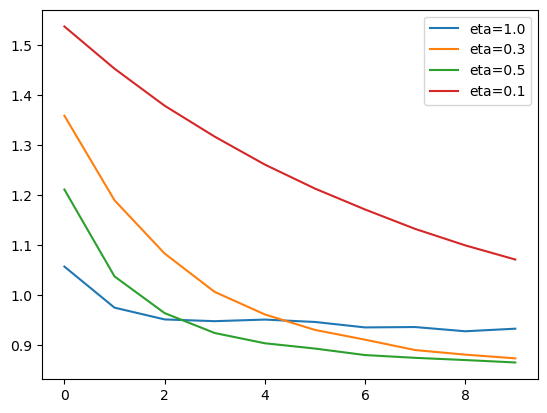

In [188]:
# tried etas
etas = ['eta=1.0','eta=0.3','eta=0.5','eta=0.1']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter,df_score.val_rmse, label=eta )
    
plt.legend()

From the graph, we got the best score of rmse from params: **eta: 0.5** 

In [189]:
best_eta=0.5

### Max Depth Tuning

In [213]:
scores = {}

In [220]:
%%capture output

xgb_params = {
    'eta': best_eta, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=10, 
                  evals=watchlist
                 )

In [221]:
# store output
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=3'

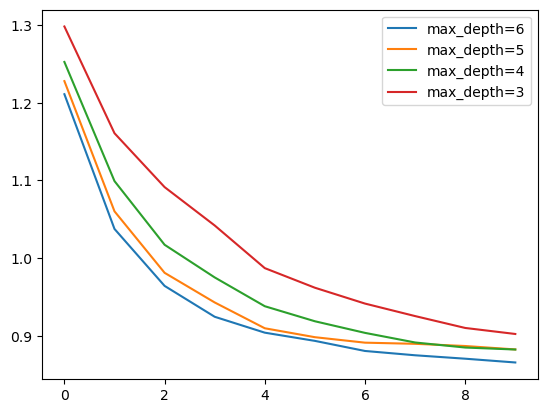

In [222]:
# tried max_depth
max_depths = ['max_depth=6','max_depth=5','max_depth=4','max_depth=3']
for max_depth in max_depths:
    df_score = scores[max_depth]
    plt.plot(df_score.num_iter,df_score.val_rmse, label=max_depth )
    
plt.legend()

From the graph, we got the best score of rmse from params: **max_depth: 6** 

In [223]:
best_max_depth = 6

### Min Child Weight

In [225]:
scores = {}

In [235]:
%%capture output

xgb_params = {
    'eta': best_eta, 
    'max_depth': best_max_depth,
    'min_child_weight': 5,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=10, 
                  evals=watchlist
                 )

In [236]:
# store output
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=5'

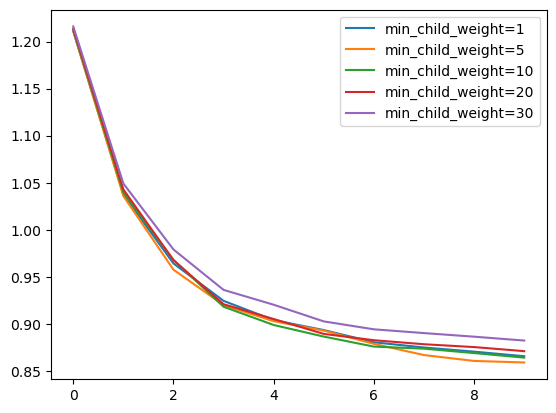

In [239]:
# tried min_child_weight
params = ['min_child_weight=1','min_child_weight=5','min_child_weight=10','min_child_weight=20','min_child_weight=30']
for param in params:
    df_score = scores[param]
    plt.plot(df_score.num_iter,df_score.val_rmse, label=param )
    
plt.legend()

From the graph, we got the best score of rmse from params: **min child weight: 30** 

In [243]:
best_min_child_weight = 5

In conclusion, below is our xgb model best params 

In [245]:
# best param from the tuning
xgb_params = {
    'eta': best_eta, 
    'max_depth': best_max_depth,
    'min_child_weight': best_min_child_weight,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

best_xgb_model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=10, 
                  evals=watchlist
                 )

[0]	train-rmse:1.18554	val-rmse:1.21108
[1]	train-rmse:0.98747	val-rmse:1.03589
[2]	train-rmse:0.89124	val-rmse:0.95758
[3]	train-rmse:0.82889	val-rmse:0.92000
[4]	train-rmse:0.79611	val-rmse:0.90284
[5]	train-rmse:0.77477	val-rmse:0.89287
[6]	train-rmse:0.75759	val-rmse:0.87880
[7]	train-rmse:0.74236	val-rmse:0.86689
[8]	train-rmse:0.73164	val-rmse:0.86066
[9]	train-rmse:0.72453	val-rmse:0.85901


## Model Selection

### Best Linear Regression Model

In [248]:
y_pred = best_linear_model.predict(X_val)

print('RMSE: {}'.format(rmse(y_val, y_pred)))

RMSE: 0.8745099271702509


### Best Decistion Tree Model

In [249]:
y_pred = best_dt.predict(X_val)

print('RMSE: {}'.format(rmse(y_val, y_pred)))

RMSE: 1.0541523660377858


### Best XGBoost Model

In [251]:
y_pred = best_xgb_model.predict(dval)

print('RMSE: {}'.format(rmse(y_val, y_pred)))

RMSE: 0.8590069214627974


We select Final best model from **XGBoost** with final **RMSE 0.8590069214627974**

## Test  with our test data using best model (XGB)

we combine our train and val dataset to set as final train dataset. Our final training with combined train and val dataset will used to test our unseen data (test data)

In [252]:
# get full train set with reseted index
df_full_train = df_full_train.reset_index(drop=True)

In [253]:
y_full_train = np.log1p(df_full_train.market_value_in_eur.values)

In [254]:
del df_full_train['market_value_in_eur']

In [257]:
#Prepare data with one hot encoding
dv = DictVectorizer(sparse=False)

train_dict = df_full_train[categorical_features + numerical_features].to_dict(orient='records')
X_full_train = dv.fit_transform(train_dict)

val_dict = df_test[categorical_features + numerical_features].to_dict(orient='records')
X_test = dv.transform(val_dict)

In [258]:
# store vectorized data to xgb's best fit data structure
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.feature_names_)

dtest = xgb.DMatrix(X_test, feature_names=dv.feature_names_)

In [265]:
# best param from the tuning
xgb_params = {
    'eta': best_eta, 
    'max_depth': best_max_depth,
    'min_child_weight': best_min_child_weight,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

final_model = xgb.train(xgb_params, 
                  dfulltrain, 
                  num_boost_round=10, 
                 )

In [266]:
y_pred = final_model.predict(dtest)

In [267]:
rmse(y_test, y_pred)

0.8910892566947074

## Use Model

Now we trying to simulate how this final model is used. \
Also we check how different in the prediction and actual price in real amount

In [270]:
# get one of  player in test dataset
df_test[numerical_features + categorical_features].iloc[50].to_dict()

{'height_in_cm': 187.0,
 'goals_2022': 0.0,
 'games_2022': 30.0,
 'assists_2022': 0.0,
 'minutes_played_2022': 2668.0,
 'goals_for_2022': 36.0,
 'goals_against_2022': 65.0,
 'clean_sheet_2022': 0.0,
 'age': 31,
 'position': 'Goalkeeper',
 'sub_position': 'Goalkeeper',
 'foot': 'right',
 'current_club_name': 'Stade Rennais FC',
 'current_club_domestic_competition_id': 'FR1'}

In [287]:
X_spesific_player = dv.transform(val_dict)
dspecificplayer = xgb.DMatrix(X_spesific_player, feature_names=dv.feature_names_)

In [296]:
y_pred = final_model.predict(dtest)[0]

Predicted price in euro

In [297]:
np.expm1(y_pred)

1934341.2

Actual Price in euro

In [298]:
np.expm1(y_test[50])

2000000.0000000016

## Save the model

In [300]:
import pickle

In [301]:
version = 1

In [303]:
output_file = f'model_v{version}.bin'
output_file

'model_v1.bin'

In [304]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, final_model), f_out)

## Load model

test saved model

In [305]:
import pickle

In [312]:
import xgboost as xgb

In [313]:
model_file = 'model_v1.bin'

In [314]:
with open(model_file,'rb') as f_in:
    dv, model = pickle.load(f_in)

In [320]:
player = {
    'height_in_cm': 187.0,
 'goals_2022': 0.0,
 'games_2022': 30.0,
 'assists_2022': 0.0,
 'minutes_played_2022': 2668.0,
 'goals_for_2022': 36.0,
 'goals_against_2022': 65.0,
 'clean_sheet_2022': 0.0,
 'age': 31,
 'position': 'Goalkeeper',
 'sub_position': 'Goalkeeper',
 'foot': 'right',
 'current_club_name': 'Stade Rennais FC',
 'current_club_domestic_competition_id': 'FR1'
}

In [321]:
X = dv.transform(player)

In [323]:
dplayer = xgb.DMatrix(X, feature_names=dv.feature_names_)

In [324]:
y_pred = model.predict(dplayer)[0]

In [326]:
np.expm1(y_pred)

1934341.2